### 데이터 불러오기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Lambda(lambda x : x.rotate(90)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 데이터 일부 확인

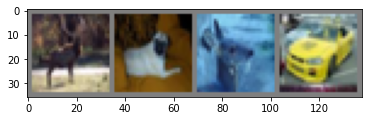

deer  dog   deer  car  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 모델 정의
이후부터 과제 진행하시면 됩니다! 위는 수정 XX

'#####으로 표시된 부분에 작성하세요!

In [4]:
import torch.nn as nn

In [5]:
print(trainset.__getitem__(0)[0].size())
# batch의 사이즈를 출력하여 확인하여 [3,32,32]인 것을 확인하였습니다. 

torch.Size([3, 32, 32])


In [6]:
# conv. layer, relu,  pooling layer, fc layer를 모두 1층 이상 사용하는 모델 Net()을 만들어주세요
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ##### 아래 작성 #####
        self.layer= nn.Sequential(
                        nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1), # [batchsize,3,32,32] ->[batchsize,16,32,32]
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3), #[batchsize,16,32,32] -> [batchsize,32,30,30]
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3), #[batchsize,32,30,30] -> [batchsize,64,28,28]
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2,stride=2), #[batchsize,64,28,28] -> [batchsize,64,14,14] n-2p-f/s +1 
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*14*14,100),
            nn.BatchNorm1d(100),                                              # [batch_size,40*14*14] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)                                                 
        )



    def forward(self, x):
       ##### 아래 작성 #####
       out = self.layer(x)
       out = out.view(out.size(0),-1)

       out = self.fc_layer(out)
       return out


net = Net()

## 손실함수, optimizer 정의
필요한 모듈을 import하고 손실함수는 CrossEntropyLoss, optimizer는 SGD를 사용해주세요.

optimizer의 하이퍼파라미터는 lr=0.001, momentum=0.9로 통일합니다.

작성한 모델이 무거워 실행 시간이 오래 걸린다면 GPU를 활용하세요.

In [7]:
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  
model=Net().to(device)

In [8]:
import torch.optim as optim  # optimizer가 담겨있는 모듈

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

## 모델 구조 확인
필요한 모듈을 import하여 모델의 구조를 확인하세요.

In [9]:
!pip install torchsummary

In [10]:
from torchsummary import summary
summary(model,(3,32,32), batch_size=4)  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 16, 32, 32]             448
       BatchNorm2d-2            [4, 16, 32, 32]              32
              ReLU-3            [4, 16, 32, 32]               0
            Conv2d-4            [4, 32, 30, 30]           4,640
       BatchNorm2d-5            [4, 32, 30, 30]              64
              ReLU-6            [4, 32, 30, 30]               0
            Conv2d-7            [4, 64, 28, 28]          18,496
       BatchNorm2d-8            [4, 64, 28, 28]             128
              ReLU-9            [4, 64, 28, 28]               0
        MaxPool2d-10            [4, 64, 14, 14]               0
           Linear-11                   [4, 100]       1,254,500
      BatchNorm1d-12                   [4, 100]             200
             ReLU-13                   [4, 100]               0
           Linear-14                   

## Train

In [11]:
# 모델을 학습

for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        x=inputs.to(device)
        y_=labels.to(device)
        optimizer.zero_grad()
        output=model.forward(x)
        loss=criterion(output,y_)
        loss.backward()
        optimizer.step()
        



        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.829
[1,  4000] loss: 1.648
[1,  6000] loss: 1.536
[1,  8000] loss: 1.459
[1, 10000] loss: 1.419
[1, 12000] loss: 1.392
[2,  2000] loss: 1.327
[2,  4000] loss: 1.297
[2,  6000] loss: 1.281
[2,  8000] loss: 1.268
[2, 10000] loss: 1.258
[2, 12000] loss: 1.259
Finished Training


## Test

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [13]:
## 아래 코드 그대로 실행

correct = 0
total = 0
model.eval()
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images.to(device))
        outputs.cpu()
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 66 %


## 클래스별 accuracy 비교

In [15]:
## 아래 코드 그대로 실행

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction.cpu():
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.1 %
Accuracy for class: car   is 83.0 %
Accuracy for class: bird  is 55.5 %
Accuracy for class: cat   is 46.2 %
Accuracy for class: deer  is 51.7 %
Accuracy for class: dog   is 60.6 %
Accuracy for class: frog  is 73.5 %
Accuracy for class: horse is 77.2 %
Accuracy for class: ship  is 79.2 %
Accuracy for class: truck is 70.0 %
